<a href="https://colab.research.google.com/github/dldowning/Fall2022-5222/blob/main/All_Features_Downing_Roberts_5222_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
%pip install emoji
import pandas as pd
import numpy as np
from statistics import mean
import nltk
from google.colab import files
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import string
import random
import seaborn as sns
from nltk.corpus import stopwords
import csv
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import re
import emoji
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 2.0 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=6740db2be5edbe6d710f92d94d1b5418d65a42efd89887efda36cf39bd6ceaee
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Creating dataframe

In [2]:
URL = "https://drive.google.com/uc?export=download&id=1C8ARH_yok3uOvirD_oKvgEmAR22SuC9R"
response = requests.get(URL)
open("train_text_labels.csv", "wb").write(response.content)

5123208

In [3]:
URL = "https://drive.google.com/uc?export=download&id=1z0URnDJ8ck38mQ4CvHi5TUkly8e46glP"
response = requests.get(URL)
open("test_text.txt", "wb").write(response.content)

1156877

In [4]:
URL = "https://drive.google.com/uc?export=download&id=1xWQ2Lpf866Be4OR8J-cJHuY1S25dWppf"
response = requests.get(URL)
open("test_labels.txt", "wb").write(response.content)

36850

In [5]:
df0 = pd.read_csv("/content/train_text_labels.csv", header=None)
df0.columns = ['Twitter', 'Label']
len(df0)

45615

In [6]:
dft = pd.read_csv("/content/test_text.txt", sep="\n", header=None, quoting=csv.QUOTE_NONE)
dft.columns = ['Twitter']
len(dft)


12284

In [7]:
dftl = pd.read_csv("/content/test_labels.txt", sep="\n", header=None)
dftl.columns = ['Label']
len(dftl)


12284

In [8]:
dft['Label']=dftl['Label']
dft.head()

,Twitter,Label
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0


In [9]:
df0['Label'].value_counts()
#0	negative
#1	neutral
#2	positive

1    20673
2    17849
0     7093
Name: Label, dtype: int64

In [10]:
#dropping the neutrals
df = df0[df0['Label'] != 1]
df.loc[df.Label == 2, 'Label'] = 1
df=df.reset_index(drop=True)
len(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


24942

In [11]:
dft = dft[dft['Label'] != 1]
dft=dft.reset_index(drop=True)
dft.loc[dft.Label == 2, 'Label'] = 1
len(df)
len(dft)

6347

In [12]:
df_original_Tweets = df[['Twitter']].copy()
dft_original_Tweets = dft[['Twitter']].copy()

In [13]:
def tweetcleanandtoke(dataframe,colname,newcolname):
  stop = stopwords.words('english')
  pattern_a = r'[^A-Za-z0-9]+' #non-alphanumeric
  pattern_b = r'\b\w{1,1}\b' #repeated words
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)

  for i in range(0, len(dataframe.index)):                       
    dataframe[colname].values[i] = dataframe[colname].values[i].lower()
    dataframe[colname].values[i] = dataframe[colname].values[i].replace('@user', '')
    dataframe[colname].values[i] = re.sub(emoji_pattern, '', dataframe[colname].values[i])
    dataframe[colname].values[i] = re.sub(pattern_a, ' ', dataframe[colname].values[i])
    dataframe[colname].values[i] = re.sub(pattern_b, '', dataframe[colname].values[i])
    

  dataframe[colname] = dataframe[colname].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  rowname = dataframe[colname].name
  dataframe[newcolname]=0
  dataframe[newcolname] = dataframe.apply(lambda row: nltk.word_tokenize(row[rowname]), axis=1)

  return dataframe
  

In [14]:
df=tweetcleanandtoke(df,'Twitter','Twitter_tokens')
dft=tweetcleanandtoke(dft,'Twitter','Twitter_tokens')

In [15]:
df['Token_len']=df['Twitter_tokens'].apply(len)
dft['Token_len']=dft['Twitter_tokens'].apply(len)



In [16]:
#Evaluating the tokens for some EDA, also verifying I have no length 0
list_of_lengths=[]
less_than_9_len=[]
for i in range (0, len(df)):
  try:
    list_of_lengths.append(len(df['Twitter_tokens'][i]));
  except:
    pass
  try:
    if len(df['Twitter_tokens'][i]) < 9:
      less_than_9_len.append(str(i));
  except:
    pass
print("These stats are for the training set")
print("The min length is: " + str(min(list_of_lengths)))
print("The max length is: " + str(max(list_of_lengths)))
print("The mean length is: " + str(mean(list_of_lengths)))
print("The number of tweets with less than 9 tokens is: " + str(len(less_than_9_len)))

These stats are for the training set
The min length is: 1
The max length is: 26
The mean length is: 11.502004650789832
The number of tweets with less than 9 tokens is: 4506


In [17]:
list_of_lengths=[]
less_than_9_len=[]
for i in range (0, len(dft)):
  try:
    list_of_lengths.append(len(dft['Twitter_tokens'][i]));
  except:
    pass
  try:
    if len(dft['Twitter_tokens'][i]) < 9:
      less_than_9_len.append(str(i));
  except:
    pass
print("These stats are for the testing set")
print("The min test length is: " + str(min(list_of_lengths)))
print("The max test length is: " + str(max(list_of_lengths)))
print("The mean test length is: " + str(mean(list_of_lengths)))
print("The number of test tweets with less than 9 tokens is: " + str(len(less_than_9_len)))

These stats are for the testing set
The min test length is: 1
The max test length is: 20
The mean test length is: 9.237277453915235
The number of test tweets with less than 9 tokens is: 2587


#Loading and extracting TSVs

In [18]:
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_freq.zip
!echo "N"| unzip /content/socialsent_hist_freq.zip

--2022-11-19 04:19:47--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_freq.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 521987 (510K) [application/zip]
Saving to: ‘socialsent_hist_freq.zip’

socialsent_hist_fre 100%[===================>] 509.75K   375KB/s    in 1.4s    

2022-11-19 04:19:49 (375 KB/s) - ‘socialsent_hist_freq.zip’ saved [521987/521987]

Archive:  /content/socialsent_hist_freq.zip
   creating: frequent_words/
  inflating: frequent_words/1850.tsv  
  inflating: frequent_words/1860.tsv  
  inflating: frequent_words/1870.tsv  
  inflating: frequent_words/1880.tsv  
  inflating: frequent_words/1890.tsv  
  inflating: frequent_words/1900.tsv  
  inflating: frequent_words/1910.tsv  
  inflating: frequent_words/1920.tsv  
  inflating: frequent_words/1930.tsv  
  inflating: frequent_words/1940.tsv  


In [19]:
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_adj.zip
!echo "N"| unzip /content/socialsent_hist_adj.zip

--2022-11-19 04:19:49--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_adj.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201855 (197K) [application/zip]
Saving to: ‘socialsent_hist_adj.zip’

socialsent_hist_adj 100%[===================>] 197.12K   181KB/s    in 1.1s    

2022-11-19 04:19:51 (181 KB/s) - ‘socialsent_hist_adj.zip’ saved [201855/201855]

Archive:  /content/socialsent_hist_adj.zip
   creating: adjectives/
  inflating: adjectives/1850.tsv     
  inflating: adjectives/1860.tsv     
  inflating: adjectives/1870.tsv     
  inflating: adjectives/1880.tsv     
  inflating: adjectives/1890.tsv     
  inflating: adjectives/1900.tsv     
  inflating: adjectives/1910.tsv     
  inflating: adjectives/1920.tsv     
  inflating: adjectives/1930.tsv     
  inflating: adjectives/1940.tsv     
  inflating: adjec

In [20]:
df_2000adj = pd.read_csv("/content/adjectives/2000.tsv", sep="\t", header=None)
df_2000adj.columns = ['Word', 'Sentiment', 'Std']
df_2000freq = pd.read_csv("/content/frequent_words/2000.tsv", sep="\t", header=None)
df_2000freq.columns = ['Word', 'Sentiment', 'Std']

In [21]:
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_subreddits.zip
!echo "N"| unzip /content/socialsent_subreddits.zip

--2022-11-19 04:19:51--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_subreddits.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15659374 (15M) [application/zip]
Saving to: ‘socialsent_subreddits.zip’

socialsent_subreddi 100%[===================>]  14.93M  2.66MB/s    in 6.4s    

2022-11-19 04:19:58 (2.34 MB/s) - ‘socialsent_subreddits.zip’ saved [15659374/15659374]

Archive:  /content/socialsent_subreddits.zip
   creating: subreddits/
  inflating: subreddits/.zip         
  inflating: subreddits/2007scape.tsv  
  inflating: subreddits/3DS.tsv      
  inflating: subreddits/4chan.tsv    
  inflating: subreddits/ACTrade.tsv  
  inflating: subreddits/AdviceAnimals.tsv  
  inflating: subreddits/amiugly.tsv  
  inflating: subreddits/Anarcho_Capitalism.tsv  
  inflating: subreddits/Android.tsv  
  inflating: subreddits

In [22]:
list_files = ['3DS.tsv', 
'4chan.tsv',
'2007scape.tsv',
'ACTrade.tsv',
'amiugly.tsv',
'BabyBumps.tsv',
'baseball.tsv',
'canada.tsv',
'CasualConversation.tsv',
'DarkNetMarkets.tsv',
'darksouls.tsv',
'elderscrollsonline.tsv',
'Eve.tsv',
'Fallout.tsv',
'fantasyfootball.tsv',
'GameDeals.tsv',
'gamegrumps.tsv',
'halo.tsv',
'Homebrewing.tsv',
'IAmA.tsv',
'india.tsv',
'jailbreak.tsv',
'Jokes.tsv',
'KerbalSpaceProgram.tsv',
'keto.tsv',
'leagueoflegends.tsv',
'Libertarian.tsv',
'magicTCG.tsv',
'MakeupAddiction.tsv',
'Naruto.tsv',
'nba.tsv',
'oculus.tsv',
'OkCupid.tsv',
'Parenting.tsv',
'pathofexile.tsv',
'raisedbynarcissists.tsv',
'Random_Acts_Of_Amazon.tsv',
'science.tsv',
'Seattle.tsv',
'TalesFromRetail.tsv',
'talesfromtechsupport.tsv',
'ultrahardcore.tsv',
'videos.tsv',
'Warthunder.tsv',
'whowouldwin.tsv',
'xboxone.tsv',
'yugioh.tsv',
]

In [23]:
list_dicts=[]
for i in range(0,len(list_files)):
    dfname='df_'+str(list_files[i])
    dfname=dfname.replace('.tsv','')
    path="/content/subreddits/" + list_files[i]
    dataframe = pd.read_csv(path, sep="\t", header=None)
    dataframe.columns = ['Word', 'Sentiment', 'Std']
    dataframe=dataframe.drop(columns=['Std'])
    list_dicts.append(dict(dataframe.values))

In [24]:
#combine dictionaries
def dict_merger(dict1, dict2):
    new_dict = {**dict1, **dict2}
    return new_dict

In [25]:
df_2000adj=df_2000adj.drop(columns='Std')
feature1=dict(df_2000adj.values)
df_2000freq=df_2000freq.drop(columns='Std')
feature2=dict(df_2000freq.values)

In [26]:
feature3 = {}
for i in range(0, 8):
  feature3=dict_merger(feature3,list_dicts[i])

feature4 = {}
for i in range(8, 16):
  feature4=dict_merger(feature4,list_dicts[i])

feature5 = {}
for i in range(16, 23):
  feature5=dict_merger(feature5,list_dicts[i])

feature6 = {}
for i in range(23, 29):
  feature6=dict_merger(feature6,list_dicts[i])

feature7 = {}
for i in range(29, 34):
  feature7=dict_merger(feature7,list_dicts[i])

feature8 = {}
for i in range(34, 41):
  feature8=dict_merger(feature8,list_dicts[i])

feature9 = {}
for i in range(41, 47):
  feature9=dict_merger(feature9,list_dicts[i])





#Extracting features

In [27]:
#one thing that boosted my scores was instead of taking one word per feature, I summed 9 words per feature
#I took words at random and oversampled shorter tweets. boosted the F1 score by letting randomization try to hit a good token
def lookups(row):
  lookup_index=row.name
  #print("This is the lookup_index: " + str(lookup_index))
  range_len=(df['Token_len'][lookup_index])
  #print("This is the range_len: " + str(range_len))
  score=[]
  for i in range(0, 9):
    #print("Starting the for loop at: " + str(i))
    token=random.randint(0, range_len) 
    token -= 1
    #print("The token is: " + str(token))
    word_tok=df.iloc[lookup_index, 2][token]
    #print("The word_tok is: " + str(word_tok))
    try:
      score.append(current_dict[word_tok])
    except:
      pass
  try:
      sum_score=sum(score)
  except:
      sum_score=0
  return sum_score

def lookupst(row):
  lookup_index=row.name
  #print("This is the lookup_index: " + str(lookup_index))
  range_len=(dft['Token_len'][lookup_index])
  #print("This is the range_len: " + str(range_len))
  score=[]
  for i in range(0, 9):
    #print("Starting the for loop at: " + str(i))
    token=random.randint(0, range_len) 
    token -= 1
    #print("The token is: " + str(token))
    word_tok=dft.iloc[lookup_index, 2][token]
    #print("The word_tok is: " + str(word_tok))
    try:
      score.append(current_dict[word_tok])
    except:
      pass
  try:
      sum_score=sum(score)
  except:
      sum_score=0
  return sum_score

def wordlengther(row):
    index=row.name
    token_list=df['Twitter_tokens'][index]
    longest_word=1
    for word in token_list:
        if longest_word<len(word):
          longest_word=len(word)
    log_long=np.log10(longest_word)
    return log_long

def wordfiver(row):
    index=row.name
    token_list=df['Twitter_tokens'][index]
    five_counts=1
    for word in token_list:
        if len(word)>=5:
          five_counts+=1
    log_five=np.log10(five_counts)
    return log_five

def wordlengthert(row):
    index=row.name
    token_list=dft['Twitter_tokens'][index]
    longest_word=1
    for word in token_list:
        if longest_word<len(word):
          longest_word=len(word)
    log_long=np.log10(longest_word)
    return log_long

def wordfivert(row):
    index=row.name
    token_list=dft['Twitter_tokens'][index]
    five_counts=1
    for word in token_list:
        if len(word)>=5:
          five_counts+=1
    log_five=np.log10(five_counts)
    return log_five

def mostpos(row):  #need the negative version too, mostneg
    index=row.name
    token_list=df['Twitter_tokens'][index]
    max_value=0
    for word in token_list:
      try: pos_value=feature3[word]   #replace with super dictionary
      except: pos_value=0
      if max_value<pos_value:
        max_value=pos_value
    return max_value

In [28]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [29]:
df['feature24']=0
df['feature24']=df.apply(mostpos,axis=1)

In [30]:
df['feature1']=0
df['feature2']=0
df['feature3']=0
df['feature4']=0
df['feature5']=0
df['feature6']=0
df['feature7']=0
df['feature8']=0
df['feature9']=0
df['feature10']=0
df['feature11']=0
df['feature12']=0


In [31]:
features_list=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9']
for i in range(0, len(features_list)):
  current_dict=list_dicts[i]
  df[features_list[i]]=df.apply(lookups, axis=1)
  dft[features_list[i]]=dft.apply(lookupst, axis=1)

In [32]:
df['feature10']=df['Token_len'].apply(np.log10)
dft['feature10']=dft['Token_len'].apply(np.log10)
df['feature11']=df.apply(wordlengther, axis=1)
df['feature12']=df.apply(wordfiver, axis=1)
dft['feature11']=dft.apply(wordlengthert, axis=1)
dft['feature12']=dft.apply(wordfivert, axis=1)

In [33]:
df['feature11']=df.apply(wordlengther, axis=1)
df['feature12']=df.apply(wordfiver, axis=1)
dft['feature11']=dft.apply(wordlengthert, axis=1)
dft['feature12']=dft.apply(wordfivert, axis=1)

In [34]:
df

,Twitter,Label,Twitter_tokens,Token_len,feature24,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,1.39,3.28,2.11,0.58,0.66,0.52,1.280000e+00,1.97,2.15,2.52,1.041393,1.361728,0.954243
1,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,3.63,0.50,-0.61,0.24,1.20,-0.94,-9.714451e-17,2.82,-2.11,0.95,1.113943,0.845098,1.000000
2,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,0.73,1.74,1.51,-6.89,0.25,-1.25,4.780000e+00,0.84,-0.10,0.28,1.079181,1.000000,0.903090
3,soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,2.50,0.32,0.25,1.41,2.05,1.27,4.740000e+00,-0.76,1.70,2.31,1.322219,0.954243,1.041393
4,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,1.75,2.62,2.73,-2.10,1.27,-0.48,4.090000e+00,-5.87,1.11,-0.34,1.000000,1.079181,0.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,michael good times 2nd greatest michael michae...,1,"[michael, good, times, 2nd, greatest, michael,...",10,0.35,2.56,3.74,4.51,1.90,-3.37,-1.380000e+00,2.72,-1.30,7.44,1.000000,0.903090,0.903090
24938,think misguided girl vip tonight suckin dick w...,0,"[think, misguided, girl, vip, tonight, suckin,...",14,2.70,1.49,0.50,3.31,0.54,-1.19,-3.000000e-02,-0.15,6.55,-1.57,1.146128,1.176091,0.903090
24939,amazing beautiful lady gaga show ac tonight lo...,1,"[amazing, beautiful, lady, gaga, show, ac, ton...",10,4.50,7.59,-1.94,0.15,-0.37,6.42,2.520000e+00,4.53,5.58,7.63,1.000000,0.954243,0.698970
24940,september arrived means apple new iphone hours...,1,"[september, arrived, means, apple, new, iphone...",11,0.87,1.21,0.81,-2.92,3.43,-1.65,-2.100000e-01,2.73,-4.27,1.69,1.041393,0.954243,1.000000


In [35]:
dft

,Twitter,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,think may finally crowd mannequinchallenge gra...,1,"[think, may, finally, crowd, mannequinchalleng...",6,3.71,5.48,-3.45,7.70,0.05,-0.66,2.13,-1.43,-1.22,0.778151,1.255273,0.778151
1,wow first hugo chavez fidel castro danny glove...,0,"[wow, first, hugo, chavez, fidel, castro, dann...",16,1.32,2.69,8.18,0.49,2.68,2.71,-0.22,-0.77,-0.01,1.204120,0.845098,1.113943
2,twitter thankyouobama shows heartfelt gratitud...,1,"[twitter, thankyouobama, shows, heartfelt, gra...",6,-0.39,4.59,-0.36,-0.58,-0.14,0.00,-1.14,1.49,2.19,0.778151,1.113943,0.845098
3,take away illegals dead people trump wins popu...,0,"[take, away, illegals, dead, people, trump, wi...",9,-2.04,1.77,-2.90,-0.36,-0.08,2.97,-3.38,-7.13,1.50,0.954243,0.903090,0.698970
4,onedirection harrystyles cute little dance,1,"[onedirection, harrystyles, cute, little, dance]",5,4.36,1.07,1.50,2.65,7.13,11.96,3.23,-2.67,3.96,0.698970,1.079181,0.698970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,al crying middle america left twice much votin...,0,"[al, crying, middle, america, left, twice, muc...",9,-2.40,-6.28,-6.60,-9.88,-1.76,-2.99,2.21,-3.01,1.22,0.954243,0.845098,0.845098
6343,even catholic pope francis dude like need hug ...,1,"[even, catholic, pope, francis, dude, like, ne...",11,-0.93,-6.87,8.48,3.49,-1.94,1.57,11.83,-1.02,10.76,1.041393,1.000000,0.602060
6344,looks like flynn pleased blocked blocked flynn,0,"[looks, like, flynn, pleased, blocked, blocked...",7,4.82,0.50,0.56,-1.26,0.19,2.23,6.28,2.67,2.15,0.845098,0.845098,0.845098
6345,trying conversation dad vegetarianism pointles...,0,"[trying, conversation, dad, vegetarianism, poi...",9,-6.17,0.64,-3.89,0.33,-2.18,-1.77,-0.53,-3.82,3.06,0.954243,1.113943,0.903090


In [36]:
df_original_Tweets.columns = ['Original Tweet']
df['Original Tweet'] = df_original_Tweets['Original Tweet']

first_column = df.pop('Original Tweet')
# insert column using insert(position,column_name,first_column) function
df.insert(0, 'Original Tweet', first_column)

In [37]:
dft_original_Tweets.columns = ['Original Tweet']
dft['Original Tweet'] = dft_original_Tweets['Original Tweet']

first_column = dft.pop('Original Tweet')
# insert column using insert(position,column_name,first_column) function
dft.insert(0, 'Original Tweet', first_column)

In [38]:
df

,Original Tweet,Twitter,Label,Twitter_tokens,Token_len,feature24,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,QT @user In the original draft of the 7th book...,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,1.39,3.28,2.11,0.58,0.66,0.52,1.280000e+00,1.97,2.15,2.52,1.041393,1.361728,0.954243
1,@user Alciato: Bee will invest 150 million in ...,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,3.63,0.50,-0.61,0.24,1.20,-0.94,-9.714451e-17,2.82,-2.11,0.95,1.113943,0.845098,1.000000
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,0.73,1.74,1.51,-6.89,0.25,-1.25,4.780000e+00,0.84,-0.10,0.28,1.079181,1.000000,0.903090
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,2.50,0.32,0.25,1.41,2.05,1.27,4.740000e+00,-0.76,1.70,2.31,1.322219,0.954243,1.041393
4,So disappointed in wwe summerslam! I want to s...,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,1.75,2.62,2.73,-2.10,1.27,-0.48,4.090000e+00,-5.87,1.11,-0.34,1.000000,1.079181,0.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,Michael from Good Times is the 2nd greatest Mi...,michael good times 2nd greatest michael michae...,1,"[michael, good, times, 2nd, greatest, michael,...",10,0.35,2.56,3.74,4.51,1.90,-3.37,-1.380000e+00,2.72,-1.30,7.44,1.000000,0.903090,0.903090
24938,Just think some misguided girl is in the VIP t...,think misguided girl vip tonight suckin dick w...,0,"[think, misguided, girl, vip, tonight, suckin,...",14,2.70,1.49,0.50,3.31,0.54,-1.19,-3.000000e-02,-0.15,6.55,-1.57,1.146128,1.176091,0.903090
24939,"@user \""""So amazing to have the beautiful Lady...",amazing beautiful lady gaga show ac tonight lo...,1,"[amazing, beautiful, lady, gaga, show, ac, ton...",10,4.50,7.59,-1.94,0.15,-0.37,6.42,2.520000e+00,4.53,5.58,7.63,1.000000,0.954243,0.698970
24940,"9 September has arrived, which means Apple's n...",september arrived means apple new iphone hours...,1,"[september, arrived, means, apple, new, iphone...",11,0.87,1.21,0.81,-2.92,3.43,-1.65,-2.100000e-01,2.73,-4.27,1.69,1.041393,0.954243,1.000000


In [39]:
dft

,Original Tweet,Twitter,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,I think I may be finally in with the in crowd ...,think may finally crowd mannequinchallenge gra...,1,"[think, may, finally, crowd, mannequinchalleng...",6,3.71,5.48,-3.45,7.70,0.05,-0.66,2.13,-1.43,-1.22,0.778151,1.255273,0.778151
1,"@user Wow,first Hugo Chavez and now Fidel Cast...",wow first hugo chavez fidel castro danny glove...,0,"[wow, first, hugo, chavez, fidel, castro, dann...",16,1.32,2.69,8.18,0.49,2.68,2.71,-0.22,-0.77,-0.01,1.204120,0.845098,1.113943
2,Twitter's #ThankYouObama Shows Heartfelt Grati...,twitter thankyouobama shows heartfelt gratitud...,1,"[twitter, thankyouobama, shows, heartfelt, gra...",6,-0.39,4.59,-0.36,-0.58,-0.14,0.00,-1.14,1.49,2.19,0.778151,1.113943,0.845098
3,@user @user @user @user @user @user take away ...,take away illegals dead people trump wins popu...,0,"[take, away, illegals, dead, people, trump, wi...",9,-2.04,1.77,-2.90,-0.36,-0.08,2.97,-3.38,-7.13,1.50,0.954243,0.903090,0.698970
4,#onedirection #harrystyles cute little dance 😉,onedirection harrystyles cute little dance,1,"[onedirection, harrystyles, cute, little, dance]",5,4.36,1.07,1.50,2.65,7.13,11.96,3.23,-2.67,3.96,0.698970,1.079181,0.698970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,@user for al the crying you do about how middl...,al crying middle america left twice much votin...,0,"[al, crying, middle, america, left, twice, muc...",9,-2.40,-6.28,-6.60,-9.88,-1.76,-2.99,2.21,-3.01,1.22,0.954243,0.845098,0.845098
6343,"i'm not even catholic, but pope francis is my ...",even catholic pope francis dude like need hug ...,1,"[even, catholic, pope, francis, dude, like, ne...",11,-0.93,-6.87,8.48,3.49,-1.94,1.57,11.83,-1.02,10.76,1.041393,1.000000,0.602060
6344,@user @user @user Looks like Flynn isn't too p...,looks like flynn pleased blocked blocked flynn,0,"[looks, like, flynn, pleased, blocked, blocked...",7,4.82,0.50,0.56,-1.26,0.19,2.23,6.28,2.67,2.15,0.845098,0.845098,0.845098
6345,Trying to have a conversation with my dad abou...,trying conversation dad vegetarianism pointles...,0,"[trying, conversation, dad, vegetarianism, poi...",9,-6.17,0.64,-3.89,0.33,-2.18,-1.77,-0.53,-3.82,3.06,0.954243,1.113943,0.903090


In [40]:
def feature_extraction13_23(dataframe):  #pass in df or dft 

  dataframe["Feature 13"] = np.nan # Count: Words in + Lexicon
  dataframe["Feature 14"] = np.nan # Count: Words in - Lexicon
  dataframe["Feature 15"] = np.nan # Count: Nouns in Tweet
  dataframe["Feature 16"] = np.nan # Count: Adjectives
  dataframe["Feature 17"] = np.nan # Ratio: Unique words - total words
  dataframe["Feature 18"] = np.nan # Ratio: Stop Words - Total Words
  dataframe["Feature 19"] = np.nan # Ratio Nouns to total words
  dataframe["Feature 20"] = np.nan # Ratio of proper nouns to total words
  dataframe["Feature 21"] = np.nan # Ratio Capital letters to lowercase letters
  dataframe["Feature 22"] = np.nan # Ratio of punctuation characters to Total Characters
  dataframe["Feature 23"] = np.nan # Does Tweet conatin the word 'No'
  dataframe["Feature 24"] = np.nan # Mean Length of all words in tweet 
  dataframe["Feature 25"] = np.nan # Log of Mean Length of all words in tweet 
  dataframe["Feature 26"] = np.nan # Highest word score of all words in tweet 
  dataframe["Feature 27"] = np.nan # Lowest word score of all words in tweet
  dataframe["Feature 28"] = np.nan # Emoji count  



  #CREATE POSITIVE AND NEGATIVE LEXICONS
  pos_lexicon = []
  neg_lexicon = []

  for i in range(0, len(list_dicts)):               
    for j in range(0, len(list_dicts[i])):    

      if list(list_dicts[i].values())[j] >= 0:         
        pos_lexicon.append(list(list_dicts[i].keys())[j])        
          
      if list(list_dicts[i].values())[j] < 0:         
        neg_lexicon.append(list(list_dicts[i].keys())[j]) 

  pos_lexicon = [*set(pos_lexicon)]   # Remove duplicate values from + lexicon
  neg_lexicon = [*set(neg_lexicon)]   # Remove duplicate values from - lexicon

  wrds_in_PosNeg = intersection(pos_lexicon, neg_lexicon)
  wrds_in_PosNeg.pop(0)


  #Look for duplicates across dictionaries 
  duplicate_dict = {}

  for i in range(0, len(wrds_in_PosNeg)):
    sent_scores_2sum = []

    for j in range(0, len(list_dicts)):
      subreddit_wrd_list = list(list_dicts[j].keys())

      if wrds_in_PosNeg[i] in subreddit_wrd_list:
        sent_scores_2sum.append(list_dicts[j].get(wrds_in_PosNeg[i]))
        num_avg = mean(sent_scores_2sum)
    
    duplicate_dict[wrds_in_PosNeg[i]] =  num_avg

  # Remove words that now have a clear positive or negative classification
  for w in duplicate_dict.items():        # .items() returns a tuple of (word, score). See Cell above for all words: scores in dict
    if w[1] >= 0:                         # if w[1] (the score) is greater than 0...
      neg_lexicon.remove(w[0])            # remove it from the negative lexicon
    if w[1] < 0:                          # If w[1] (the score) is less than 0...
      pos_lexicon.remove(w[0])            # remove the word from the positive lexicon


  # COUNT POSITIVE AND NEGATIVE WORDS (13 & 14)
  neg_lex_set = set(neg_lexicon)
  pos_lex_set = set(pos_lexicon)

  for i in range(0, len(dataframe.index)):
    x = set(dataframe['Twitter_tokens'][i])
    dataframe['Feature 13'].values[i] = len(x.intersection(pos_lex_set))
    dataframe['Feature 14'].values[i] = len(x.intersection(neg_lex_set))


  # COUNT NOUNS IN TWEET (15)
  for i in range(0, len(dataframe.index)):
    tokens = dataframe['Twitter_tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    noun_definitions = ['NN', 'NNS', 'NNP', 'NNPS']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in noun_definitions:
        count += 1
    
    dataframe['Feature 15'].values[i] = count  


  #COUNT ADJECTIVES IN TWEET (16)
  for i in range(0, len(dataframe.index)):
    tokens = dataframe['Twitter_tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    adj_definitions = ['JJ', 'JJR', 'JJS ']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in adj_definitions:
        count += 1
    
    dataframe['Feature 16'].values[i] = count

  # RATIO: UNIQUE TO TOTAL WORDS (17)
  for i in range(0, len(dataframe.index)):                       
    tokens = dataframe['Twitter_tokens'][i]
    x = np.array(tokens)
    ratio = len(np.unique(x)) / len(tokens)
    dataframe['Feature 17'].values[i] = ratio


  # STOP WORDS TO TOTAL WORDS (18)
  for i in range(0, len(dataframe.index)):                       
    tokens = dataframe['Twitter_tokens'][i]
    x = np.array(tokens)
    stop_wrds_count = [w for w in tokens if w in stop_words]
    ratio = len(stop_wrds_count) / len(tokens)
    dataframe['Feature 18'].values[i] = ratio


  # RATIO OF NOUNS TO TOTAL WORDS (19)

  for i in range(0, len(dataframe.index)):
      tokens = dataframe['Twitter_tokens'][i]
      tokens = [w for w in tokens if not w in stop_words]
      tagged = nltk.pos_tag(tokens)

      noun_definitions = ['NN', 'NNS', 'NNP', 'NNPS']
      count = 0

      for j in range(0, len(tagged)):
        if tagged[j][1] in noun_definitions:
          count += 1

      ratio = count / len(dataframe['Twitter_tokens'][i])
      dataframe['Feature 19'].values[i] = ratio

     
  # RATIO OF PROPER NOUNS TO TOTAL WORDS (20)

  for i in range(0, len(dataframe.index)):
      tokens = dataframe['Twitter_tokens'][i]
      tokens = [w for w in tokens if not w in stop_words]
      tagged = nltk.pos_tag(tokens)

      noun_definitions = ['NNP', 'NNPS']
      count = 0

      for j in range(0, len(tagged)):
        if tagged[j][1] in noun_definitions:
          count += 1

      ratio = count / len(dataframe['Twitter_tokens'][i])
      dataframe['Feature 20'].values[i] = ratio

  # RATIO OF CAPITAL LETTERS TO LOWERCASE LETERS(21)
  for i in range(0, len(dataframe.index)):
    upper_count = len(re.findall(r'[A-Z]', dataframe['Original Tweet'].values[i]))
    lower_count = len(re.findall(r'[a-z]', dataframe['Original Tweet'].values[i]))

    if lower_count == 0:
      dataframe['Feature 21'].values[i] = 0 
    if lower_count!= 0: 
      ratio = upper_count / lower_count
      dataframe['Feature 21'].values[i] = ratio


  # RATIO PUNCTUATION CHARACTERS TO TOTAL CHARACTERS (22)
  for i in range(0, len(dataframe.index)):
    count = 0

    for j in dataframe['Original Tweet'][i]:
      if j in string.punctuation:
        count += 1

    ratio = count / len(dataframe['Original Tweet'][i])
    dataframe['Feature 22'].values[i] = ratio


  # DOES TWEET CONTAIN NO (23)
  for i in range(0, len(dataframe.index)):                       # In the range 0 to length of the tweets dataframe         # Tokenize and lowercase tweets 
    if 'no' in dataframe['Twitter_tokens'][i]:                                    # If no is in tweet dataframe value is 1 if not value is zero
      dataframe['Feature 23'].values[i] = 1
    else: 
      dataframe['Feature 23'].values[i] = 0

  # MEAN LENGTH OF WORDS IN TWEET (24)
  for i in range(0, len(dataframe.index)):
    average = sum(len(token) for token in dataframe['Twitter_tokens'][i]) / len(dataframe['Twitter_tokens'][i])

    dataframe['Feature 24'].values[i] = average



  # LOG MEAN LENGTH OF WORDS IN TWEET (25)
  for i in range(0, len(dataframe.index)):
    average = sum(len(token) for token in dataframe['Twitter_tokens'][i]) / len(dataframe['Twitter_tokens'][i])

    dataframe['Feature 25'].values[i] = math.log(average)


  # HIGHEST SCORE VALUE OF TOKENS (26)
  dataframe['Feature 26'] = dataframe['Feature 26'].astype('object')

  for i in range(0, len(dataframe.index)):
    found_values = []

    for j in range(0 , len(dataframe['Twitter_tokens'][i])):
      if dataframe['Twitter_tokens'][i][j] in super_dict:
        found_values.append(super_dict.get(dataframe['Twitter_tokens'][i][j])) 

      if not found_values:
        found_values.append(0) 

    dataframe['Feature 26'].values[i] = max(found_values)


  # LOWEST SCORE VALUE OF TOKENS (27)
  dataframe['Feature 27'] = dataframe['Feature 27'].astype('object')

  for i in range(0, len(dataframe.index)):
    found_values = []

    for j in range(0 , len(dataframe['Twitter_tokens'][i])):
      if dataframe['Twitter_tokens'][i][j] in super_dict:
        found_values.append(super_dict.get(dataframe['Twitter_tokens'][i][j])) 

      if not found_values:
        found_values.append(0) 

    dataframe['Feature 27'].values[i] = min(found_values)


  # COUNT EMOJIS (28)
  for i in range(0, len(dataframe.index)):
    count = len(re.findall(r'[\U0001f600-\U0001f650]', dataframe['Original Tweet'][i]))

    dataframe['Feature 28'].values[i] = count

  return(dataframe)

In [41]:
# Combination of all subreddit dict values into one dict 
super_dict = {}
for i in range(0, len(list_dicts)):
  super_dict=dict_merger(super_dict,list_dicts[i])

In [42]:
df_updated = feature_extraction13_23(df)
dft_updated = feature_extraction13_23(dft)

In [43]:
df = df_updated
dft = dft_updated

#Forward Selection of Features

In [56]:
dfc=pd.concat([df, dft])
Xc=dfc.drop(columns=['Twitter','Label','Twitter_tokens','Token_len','Original Tweet','feature24']) #whats wrong with feature24?
yc=dfc['Label']

In [57]:
def best_feature_maker(x,y):
  X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 50))
  sel.fit(X_train, y_train)
  print("The best features to use are: ")
  feature_index = sel.get_support(indices=True)
  x_new=x.iloc[:,feature_index]
  print(x_new.head())
  return x_new

In [75]:
Xc_selected=best_feature_maker(Xc,yc)

The best features to use are: 
   feature1  feature2  feature3  feature4  feature5      feature6  feature7  \
0      3.28      2.11      0.58      0.66      0.52  1.280000e+00      1.97   
1      0.50     -0.61      0.24      1.20     -0.94 -9.714451e-17      2.82   
2      1.74      1.51     -6.89      0.25     -1.25  4.780000e+00      0.84   
3      0.32      0.25      1.41      2.05      1.27  4.740000e+00     -0.76   
4      2.62      2.73     -2.10      1.27     -0.48  4.090000e+00     -5.87   

   feature8  feature9  Feature 13  Feature 14  Feature 21  Feature 22  \
0      2.15      2.52         7.0         1.0    0.130952    0.033898   
1     -2.11      0.95         8.0         3.0    0.066667    0.034783   
2     -0.10      0.28         5.0         4.0    0.238095    0.068627   
3      1.70      2.31        14.0         5.0    1.611111    0.121429   
4      1.11     -0.34         3.0         5.0    0.033898    0.012658   

  Feature 26 Feature 27  
0       1.57      -0.44  
1  

#LogReg

In [59]:
class LogRegression:
    def __init__(self, feature_number, lr, epochs):      
        self.intercept = 0
        self.weight = np.zeros(feature_number)
        self.lr = lr
        self.epochs = epochs


    def sigmoid(self, X):
        z = np.dot(X, self.weight) + self.intercept
        return 1 / (1 + np.exp(-z))
    
    def loss(self, s, y):
        return (-y * np.log(s) - (1 - y) * np.log(1 - s)).mean()
    
    def gradient_descent(self, X, s, y):
        return np.dot(X.T, (s - y)) / y.shape[0]
    
    def gradient_descent_intercept(self, s, y):
        return np.mean(s - y)

    def fit(self, X, y):
        losses = []
        for i in range(self.epochs):
            sigma = self.sigmoid(X)

            dW = self.gradient_descent(X , sigma, y)
            dintercept = self.gradient_descent_intercept(sigma, y)

            self.weight -= self.lr * dW
            self.intercept -= self.lr * dintercept

            loss = self.loss(sigma, y)
            if len(losses) % 1000 == 0:
                print("The iteration is " + str(i) + " and the loss is " +  str(loss))
            losses.append(loss)
            if i > 1000:
              if losses[-1] > losses[-100] - .0001:     #the difference should be an argument
                print("The weight is ")
                print(self.weight)
                print("The intercept is ")
                print(self.intercept)
                break
        return losses
    
    def predict(self, train):
        x_new = train
        result = self.sigmoid(x_new)
        y_pred = np.zeros(result.shape[0])
        for i in range(len(y_pred)):
            if result[i] >= 0.5: 
                y_pred[i] = 1
            else:
                y_pred[i] = 0
                continue
                
        return y_pred
      
    def metrics(self, pred, test):
        y_pred=pred
        y_test=test
        tp=(sum((y_pred == 1) & (y_test==1)))
        fp=(sum((y_pred == 1) & (y_test==0)))
        fn=(sum((y_pred == 0) & (y_test==1)))
        tn=(sum((y_pred == 0) & (y_test==0)))
        confusion_matrix=[[tn, fp], [fn, tp]]
        print("The confusion matrix is: ")
        print(confusion_matrix[0])
        print(confusion_matrix[1])
        print('The accuracy for the Twitter sentiment is {}'.format(sum(y_pred == y_test) / y_test.shape[0]))
        print('The precision for the Twitter sentiment is {}'.format((tp/(tp+fp))))
        print('The recall for the Twitter sentiment is {}'.format((tp/(tp+fn))))
        print('The F1 score for the Twitter sentiment is {}'.format((2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fn))+(tp/(tp+fp))))))
        return confusion_matrix

In [60]:
df.head()

,Original Tweet,Twitter,Label,Twitter_tokens,Token_len,feature24,feature1,feature2,feature3,feature4,...,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28
0,QT @user In the original draft of the 7th book...,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,1.39,3.28,2.11,0.58,0.66,...,0.636364,0.0,0.130952,0.033898,0.0,7.000000,1.945910,1.57,-0.44,0.0
1,@user Alciato: Bee will invest 150 million in ...,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,3.63,0.50,-0.61,0.24,1.20,...,0.384615,0.0,0.066667,0.034783,0.0,5.230769,1.654558,1.52,-0.83,0.0
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,0.73,1.74,1.51,-6.89,0.25,...,0.583333,0.0,0.238095,0.068627,0.0,5.416667,1.689481,3.36,-3.12,0.0
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,2.50,0.32,0.25,1.41,2.05,...,0.523810,0.0,1.611111,0.121429,0.0,4.428571,1.488077,2.65,-0.44,0.0
4,So disappointed in wwe summerslam! I want to s...,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,1.75,2.62,2.73,-2.10,1.27,...,0.500000,0.0,0.033898,0.012658,0.0,5.300000,1.667707,1.55,-1.65,0.0


In [ ]:
dft.head()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
Xc, yc, test_size=0.2, random_state=42)

In [ ]:
#experimented with different splits, best performance was to concatenate the train and test sets
#and then randomly resample them to create new train and test sets
#this gave better variance and improved the score
"""
X_train=df.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])
X_test=dft.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])
y_train=df['Label']
y_test=dft['Label']
X=X_train
y=y_train
"""

In [62]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
#very minor boost in performance since our features are already of similar scale, but did give a boost

In [63]:
feature_number, lr, epochs = X_train.shape[1], .5, 1000000

LogRegSent = LogRegression(feature_number, lr, epochs)

losses = LogRegSent.fit(X_train_norm, y_train)

The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.5150547527386746
The iteration is 2000 and the loss is 0.5105674722707798
The iteration is 3000 and the loss is 0.5082939009504399
The iteration is 4000 and the loss is 0.5067911279795699
The weight is 
[ 3.88718406  1.35110688  0.19007335  1.22333126 -0.81680121  0.87911775
 -0.11038861  2.02056978  1.52998215 -0.79551275  0.32910098 -0.85426255
  3.19578628 -4.41007129  0.83225729 -0.15324494 -0.9227016   0.04407588
 -1.01677211  0.65734686 -0.05491463  0.31966306  0.         -0.07050237
 -0.46171003  1.18255135  1.17623994 -0.01384957]
The intercept is 
-3.68690697390391


<function matplotlib.pyplot.show(*args, **kw)>

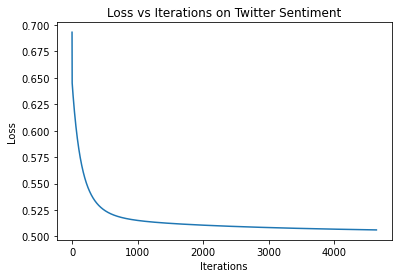

In [64]:
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations on Twitter Sentiment")
plt.plot(losses)
plt.show


In [65]:
y_pred = LogRegSent.predict(X_test_norm)

In [66]:
cm = LogRegSent.metrics(y_pred, y_test)

The confusion matrix is: 
[1168, 1017]
[505, 3568]
The accuracy for the Twitter sentiment is 0.7567913071268776
The precision for the Twitter sentiment is 0.7781897491821156
The recall for the Twitter sentiment is 0.8760127670022096
The F1 score for the Twitter sentiment is 0.8242088242088242


#Test 1 Additional Feature

In [71]:
def try_add_feature(x,y,feat,target):
  x_1=x
  x_1.insert(1, feat.name, feat)
  X_train, X_test, y_train, y_test = train_test_split(x_1, y, test_size=0.2, random_state=42)
  X_train_norm, X_test_norm = mms.fit_transform(X_train), mms.transform(X_test)
  feature_number, lr, epochs = X_train.shape[1], .5, 1000000
  LogRegSent = LogRegression(feature_number, lr, epochs)
  losses = LogRegSent.fit(X_train_norm, y_train)
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title("Loss vs Iterations on Twitter Sentiment")
  plt.plot(losses)
  plt.show
  y_pred = LogRegSent.predict(X_test_norm)
  cm = LogRegSent.metrics(y_pred, y_test)
  f1=(2*cm[1][1]/(cm[1][1]+cm[0][1]))*(cm[1][1]/(cm[1][1]+cm[1][0]))/((cm[1][1]/(cm[1][1]+cm[1][0]))+(cm[1][1]/(cm[1][1]+cm[0][1])))
  print("The F1 with " + str(feat.name) + " is: " + str(f1) + " but the target was: " +str(target))
  diff=target-f1
  print("The difference in F1 score with " + str(feat.name) + " is: " + str(diff))
  return diff



In [72]:
  features_selected = Xc_selected.columns
  all_features=Xc.columns
  removed_features_names=[]
  removed_features=[]
  for i in range(0,len(all_features)):
    good=0
    for j in range(0,len(features_selected)):
      if all_features[i] == features_selected[j]:
        good-=1
    if good==0:
      removed_features_names.append(Xc.columns[i])

  for k in range(0,len(removed_features_names)):
    removed_features.append(Xc[removed_features_names[k]])
    print("Adding " + str(removed_features_names[k]) + " to the removed features list")




Adding feature10 to the removed features list
Adding feature11 to the removed features list
Adding feature12 to the removed features list
Adding Feature 15 to the removed features list
Adding Feature 16 to the removed features list
Adding Feature 17 to the removed features list
Adding Feature 18 to the removed features list
Adding Feature 19 to the removed features list
Adding Feature 20 to the removed features list
Adding Feature 23 to the removed features list
Adding Feature 24 to the removed features list
Adding Feature 25 to the removed features list
Adding Feature 28 to the removed features list


The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.518310228200254
The iteration is 2000 and the loss is 0.5129906042587983
The iteration is 3000 and the loss is 0.5102457126380036
The iteration is 4000 and the loss is 0.5084182392908927
The iteration is 5000 and the loss is 0.5071476279814974
The weight is 
[ 3.96141705 -0.74852037  1.30948604  0.02546259  1.1546476  -1.1914445
  0.82472448 -0.13659851  1.87459628  1.64901295  3.42466022 -4.30839199
 -0.06725516  0.48953576  1.27012457  1.17597247]
The intercept is 
-5.301379389549697
The confusion matrix is: 
[1153, 1032]
[506, 3567]
The accuracy for the Twitter sentiment is 0.7542345797379354
The precision for the Twitter sentiment is 0.7756033920417482
The recall for the Twitter sentiment is 0.8757672477289468
The F1 score for the Twitter sentiment is 0.8226476014760148
The F1 with feature10 is: 0.8226476014760148 but the target was: 0.8242088242088242
The difference in F1 score with featu

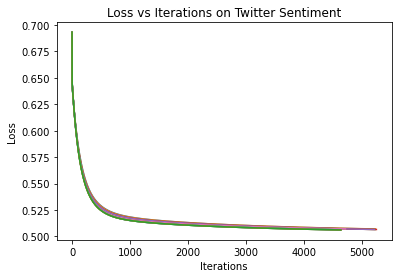

In [76]:
f1_diff_add=[]
f1_selected = 0.8242088242088242
for i in range(0,len(removed_features)):
  new=removed_features[i]
  Xc_OG=Xc_selected
  difference=try_add_feature(Xc_OG,yc,new,f1_selected)
  f1_diff_add.append(difference)
  print("---------------")
for i in range(0,len(removed_features)):
  print("To remove " + str(removed_features[i]) + " there was a loss of " + str(f1_diff_add[i]) + " in F1")

In [78]:
for i in range(0,len(removed_features)):
  print("To remove " + str(removed_features[i].name) + " there was a loss of " + str(f1_diff_add[i]) + " in F1")

To remove feature10 there was a loss of 0.001561222732809453 in F1
To remove feature11 there was a loss of 0.0017659703644463676 in F1
To remove feature12 there was a loss of 0.00199686392251619 in F1
To remove Feature 15 there was a loss of 0.002091774687873027 in F1
To remove Feature 16 there was a loss of 0.002310002310002335 in F1
To remove Feature 17 there was a loss of 0.002961711044851878 in F1
To remove Feature 18 there was a loss of 0.002961711044851878 in F1
To remove Feature 19 there was a loss of 0.00046200046200051137 in F1
To remove Feature 20 there was a loss of 0.0007337779981033687 in F1
To remove Feature 23 there was a loss of 0.0007337779981033687 in F1
To remove Feature 24 there was a loss of 8.125314342100065e-05 in F1
To remove Feature 25 there was a loss of -9.520721083611239e-05 in F1
To remove Feature 28 there was a loss of 0.0 in F1


#Try 1 Remove Feature

In [67]:
def try_remove_feature(x,y,feat,target):
  x_1=x
  x_1=x_1.drop(columns=feat)
  X_train, X_test, y_train, y_test = train_test_split(x_1, y, test_size=0.2, random_state=42)
  X_train_norm, X_test_norm = mms.fit_transform(X_train), mms.transform(X_test)
  feature_number, lr, epochs = X_train.shape[1], .5, 1000000
  LogRegSent = LogRegression(feature_number, lr, epochs)
  losses = LogRegSent.fit(X_train_norm, y_train)
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title("Loss vs Iterations on Twitter Sentiment")
  plt.plot(losses)
  plt.show
  y_pred = LogRegSent.predict(X_test_norm)
  cm = LogRegSent.metrics(y_pred, y_test)
  f1=(2*cm[1][1]/(cm[1][1]+cm[0][1]))*(cm[1][1]/(cm[1][1]+cm[1][0]))/((cm[1][1]/(cm[1][1]+cm[1][0]))+(cm[1][1]/(cm[1][1]+cm[0][1])))
  print("The F1 with " + str(feat) + " is: " + str(f1) + " but the target was: " +str(target))
  diff=target-f1
  print("The difference in F1 score without " + str(feat) + " is: " + str(diff))
  return diff



The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.5195032834191019
The iteration is 2000 and the loss is 0.5166754381451932
The iteration is 3000 and the loss is 0.5153853357807695
The weight is 
[ 1.38788573  0.42138254  1.33821941 -0.40812539  0.98464068  0.13472333
  1.97333996  1.72094986 -0.5082399   0.2135605  -0.82109479  3.40225034
 -4.55484692  0.5213249  -0.12816906 -0.85950083  0.03213392 -0.82745052
  0.5021736  -0.04294552  0.31335241  0.         -0.13379037 -0.45237655
  1.16061248  1.31735088 -0.02851458]
The intercept is 
-2.404582314802324
The confusion matrix is: 
[1141, 1044]
[508, 3565]
The accuracy for the Twitter sentiment is 0.7519974432726111
The precision for the Twitter sentiment is 0.7734866565415491
The recall for the Twitter sentiment is 0.8752762091824208
The F1 score for the Twitter sentiment is 0.8212393457728634
The F1 with feature1 is: 0.8212393457728634 but the target was: 0.8242088242088242
The difference i

AttributeError: ignored

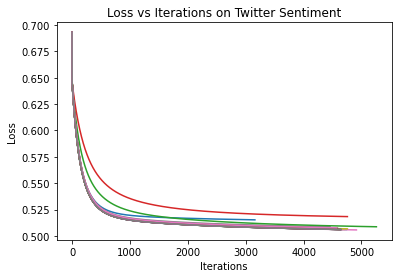

In [68]:
all_features=Xc.columns
f1_diff_rem=[]
f1_selected = 0.8242088242088242
for i in range(0,len(all_features)):
  new=all_features[i]
  difference=try_remove_feature(Xc,yc,new,f1_selected)
  f1_diff_rem.append(difference)
  print("---------------")
for i in range(0,len(all_features)):
  print("To remove " + str(all_features[i].name) + " there was a loss of " + str(f1_diff_rem[i]) + " in F1")

In [70]:
for i in range(0,len(all_features)):
  print("To remove " + str(all_features[i]) + " there was a loss of " + str(f1_diff_rem[i]) + " in F1")

To remove feature1 there was a loss of 0.0029694784359608484 in F1
To remove feature2 there was a loss of 0.00012300116118313387 in F1
To remove feature3 there was a loss of 9.518522048845846e-05 in F1
To remove feature4 there was a loss of 0.0008831891048981522 in F1
To remove feature5 there was a loss of 9.518522048845846e-05 in F1
To remove feature6 there was a loss of 0.00047610531481501184 in F1
To remove feature7 there was a loss of 9.518522048845846e-05 in F1
To remove feature8 there was a loss of 0.00230362402474682 in F1
To remove feature9 there was a loss of -0.0003667618865678124 in F1
To remove feature10 there was a loss of 0.0005571323275446183 in F1
To remove feature11 there was a loss of 0.00042129534046397854 in F1
To remove feature12 there was a loss of 0.0010324622512989379 in F1
To remove Feature 13 there was a loss of 0.002373053161951133 in F1
To remove Feature 14 there was a loss of 0.008221761716043718 in F1
To remove Feature 15 there was a loss of 0.000597873533

#Visualizations

In [ ]:
"""
some visualization of how much the F1 difference is for each feature
order the features from best to worst with a label of each feature
that way we can try to describe why the best measured better
and why the worst measured worse
"""

In [80]:
"""
try remove one
To remove feature1 there was a loss of 0.0029694784359608484 in F1
To remove feature2 there was a loss of 0.00012300116118313387 in F1
To remove feature3 there was a loss of 9.518522048845846e-05 in F1
To remove feature4 there was a loss of 0.0008831891048981522 in F1
To remove feature5 there was a loss of 9.518522048845846e-05 in F1
To remove feature6 there was a loss of 0.00047610531481501184 in F1
To remove feature7 there was a loss of 9.518522048845846e-05 in F1
To remove feature8 there was a loss of 0.00230362402474682 in F1
To remove feature9 there was a loss of -0.0003667618865678124 in F1
To remove feature10 there was a loss of 0.0005571323275446183 in F1
To remove feature11 there was a loss of 0.00042129534046397854 in F1
To remove feature12 there was a loss of 0.0010324622512989379 in F1
To remove Feature 13 there was a loss of 0.002373053161951133 in F1
To remove Feature 14 there was a loss of 0.008221761716043718 in F1
To remove Feature 15 there was a loss of 0.0005978735330705032 in F1
To remove Feature 16 there was a loss of -0.00040727093030523687 in F1
To remove Feature 17 there was a loss of -4.0598423970195086e-05 in F1
To remove Feature 18 there was a loss of 0.0 in F1
To remove Feature 19 there was a loss of 0.0028545371739270298 in F1
To remove Feature 20 there was a loss of 0.00019034845824683622 in F1
To remove Feature 21 there was a loss of 0.0 in F1
To remove Feature 22 there was a loss of -0.0003262341254717249 in F1
To remove Feature 23 there was a loss of 0.0 in F1
To remove Feature 24 there was a loss of 4.06171847946446e-05 in F1
To remove Feature 25 there was a loss of 8.125314342100065e-05 in F1
To remove Feature 26 there was a loss of 0.0010050414848016276 in F1
To remove Feature 27 there was a loss of 0.002701959088251993 in F1
To remove Feature 28 there was a loss of -9.520721083611239e-05 in F1
"""

'\ntry remove one\nTo remove feature1 there was a loss of 0.0029694784359608484 in F1\nTo remove feature2 there was a loss of 0.00012300116118313387 in F1\nTo remove feature3 there was a loss of 9.518522048845846e-05 in F1\nTo remove feature4 there was a loss of 0.0008831891048981522 in F1\nTo remove feature5 there was a loss of 9.518522048845846e-05 in F1\nTo remove feature6 there was a loss of 0.00047610531481501184 in F1\nTo remove feature7 there was a loss of 9.518522048845846e-05 in F1\nTo remove feature8 there was a loss of 0.00230362402474682 in F1\nTo remove feature9 there was a loss of -0.0003667618865678124 in F1\nTo remove feature10 there was a loss of 0.0005571323275446183 in F1\nTo remove feature11 there was a loss of 0.00042129534046397854 in F1\nTo remove feature12 there was a loss of 0.0010324622512989379 in F1\nTo remove Feature 13 there was a loss of 0.002373053161951133 in F1\nTo remove Feature 14 there was a loss of 0.008221761716043718 in F1\nTo remove Feature 15 t

In [ ]:
"""
try add one
To remove feature10 there was a loss of 0.001561222732809453 in F1
To remove feature11 there was a loss of 0.0017659703644463676 in F1
To remove feature12 there was a loss of 0.00199686392251619 in F1
To remove Feature 15 there was a loss of 0.002091774687873027 in F1
To remove Feature 16 there was a loss of 0.002310002310002335 in F1
To remove Feature 17 there was a loss of 0.002961711044851878 in F1
To remove Feature 18 there was a loss of 0.002961711044851878 in F1
To remove Feature 19 there was a loss of 0.00046200046200051137 in F1
To remove Feature 20 there was a loss of 0.0007337779981033687 in F1
To remove Feature 23 there was a loss of 0.0007337779981033687 in F1
To remove Feature 24 there was a loss of 8.125314342100065e-05 in F1
To remove Feature 25 there was a loss of -9.520721083611239e-05 in F1
To remove Feature 28 there was a loss of 0.0 in F1
"""

#Verify our LogReg against sklearn

In [ ]:
#calling sklearn to compare. checks out my math above is correct!
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_twitter = confusion_matrix(y_test, y_pred)
print("The confusion matrix for Twitter sentinment:")
print(confusion_matrix_twitter)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_twitter)
disp.plot()
plt.show()

In [ ]:
from sklearn import metrics 
print("The confusion matrix for Twitter sentiment:")
print(confusion_matrix_twitter)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#I implemented it from scratch above, just using this as a benchmark to test my code. 
#My code's metrics are really really close so I consider that a win
from sklearn import metrics  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#X=np.concatenate((X_train_norm, X_test_norm))
#y=np.concatenate((y_train, y_test))
#y.loc[y.Label == 2, 'Label'] = 1
X_train2, X_test2, y_train2, y_test2 = train_test_split(
Xc, yc, test_size=0.33, random_state=42)
#X_train2, X_test2, y_train2, y_test2 = X_train_norm, X_test_norm, y_train, y_test
goodmodel = LogisticRegression()
goodmodel.fit(X_train2, y_train2)
y_pred2 = pd.Series(goodmodel.predict(X_test2))
confusion_matrix_twitter2 = confusion_matrix(y_test2, y_pred2)
print("The confusion matrix for Twitter sentiment:")
print(confusion_matrix_twitter2)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_twitter2)
disp.plot()
plt.show()
print("Accuracy:", metrics.accuracy_score(y_test2, y_pred2))
print("Precision:", metrics.precision_score(y_test2, y_pred2))
print("Recall:", metrics.recall_score(y_test2, y_pred2))
print("F1:"), metrics.f1_score(y_test2, y_pred2)

In [ ]:
y_test2

In [ ]:
y_pred2

In [ ]:
print("Complete")

In [ ]:
# Allow about 16min for runtime
#Extract all features and put them in on data frame

def feature_extraction(data_location, label_location):
  df = pd.read_csv(data_location, header=None)
  df.columns = ['TWEET']

  df["Tweet Tokens"] = np.nan
  df["Count: Words in + Lexicon"] = np.nan
  df["Count: Words in - Lexicon"] = np.nan
  df["Contain The word NO? "] = np.nan
  df["Count: Nouns"] = np.nan
  df["Ratio: Unique Words-Total Words"] = np.nan
  df["Ratio: Stop Words-Total Words"] = np.nan
  df["Count: Adjectives in Tweet"] = np.nan
  df["Log: Tweet word count"] = np.nan
  df["Log: Length of Longest Word in Tweet"] = np.nan
  df["Log: Count of Words with 5+ Characters"] = np.nan

  # ADD LABELS COLUMN TO DF 
  labels = pd.read_csv(label_location, sep="\n", header=None)
  df = pd.concat([df,labels], axis = 1)
  df.rename(columns = {0:'Labels'}, inplace = True)

  # DROP NEUTRAL LABELS FROM DF
  df.drop(df.loc[df['Labels']==1].index, inplace=True)
  df = df.reset_index(drop=True)

  # CHANGE ALL 2 LABEL VALUES TO 1 
  for i in range(0, len(df.index)):
    if df['Labels'].values[i] == 2:
      df.at[i,'Labels'] = 1

  # CLEAN TWEETS
  pattern_a = r'[^A-Za-z0-9]+'
  pattern_b = r'\b\w{1,1}\b'
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)

  for i in range(0, len(df.index)):                       
    df['TWEET'].values[i] = df['TWEET'].values[i].lower()
    df['TWEET'].values[i] = df['TWEET'].values[i].replace('@user', '')
    df['TWEET'].values[i] = re.sub(pattern_a, ' ', df['TWEET'].values[i])
    df['TWEET'].values[i] = re.sub(pattern_b, '', df['TWEET'].values[i])
    df['TWEET'].values[i] = re.sub(emoji_pattern, '', df['TWEET'].values[i])

  #TOKENIZE TWEETS
  df['Tweet Tokens'] = df['Tweet Tokens'].astype('object')
  for i in range(0, len(df.index)):
    
    tokens = df['TWEET'].values[i].split()
    df.at[i, 'Tweet Tokens'] = tokens

  #Create Positive and Negative Lexicons
  pos_lexicon = []
  neg_lexicon = []

  for i in range(0, len(subreddit_dataframes)):               
    for j in range(0, len(subreddit_dataframes[i].index)):    

      if subreddit_dataframes[i]['Sentiment Score'].values[j] >= 0:         
        pos_lexicon.append(subreddit_dataframes[i]['Word'].values[j])        
      
      if subreddit_dataframes[i]['Sentiment Score'].values[j] < 0:         
        neg_lexicon.append(subreddit_dataframes[i]['Word'].values[j])        


  pos_lexicon = [*set(pos_lexicon)]   # Remove duplicate values from + lexicon
  neg_lexicon = [*set(neg_lexicon)]   # Remove duplicate values from - lexicon


  #Handle duplicate words in postitive and negative lexicon
  same_wrds = set(pos_lexicon).intersection(neg_lexicon)      #get set of all words that appear in both psoitive and Negative Lexicon
                                                              #https://stackoverflow.com/questions/1388818/how-can-i-compare-two-lists-in-python-and-return-matches

  word_vals_dict = dict.fromkeys(same_wrds, 0)                # Create a dictionary to hold of all words found in positive and negative lexicons     
  sentiment_vals2sum = []

  for k in range(0, len(same_wrds)):    # In the set of words identified in positive and negative lexicon
  
    i = same_wrds.pop()                 # i will return one word from the set, then the following with each iteration
    same_wrds.add(i)                    # https://stackoverflow.com/questions/59825/how-to-retrieve-an-element-from-a-set-without-removing-it

    sentiment_vals2sum = []             # Will store the Sentiment Scores collected across data frames 

    for j in range(0, len(subreddit_dataframes)):                    # in range of dataframes(44)
      is_wrd_there = i in subreddit_dataframes[j]['Word'].unique()   # Return true or false. True if desired word 'i' is in the data frame being checked false if not (ls_df_names[0], ls_df_names[1],...)
      if is_wrd_there is True:                              # If true... 

        mask1 = subreddit_dataframes[j]['Word'].values == i                  # Get the sentiment value of the word from its dataframe 
                                                                    # https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values
                                                      
        sentiment_vals2sum.append(subreddit_dataframes[j][mask1].iat[0,1])   # append sentiment value to list where they are stored eg. sentiment_vals2sum 
        num_avg = mean(sentiment_vals2sum)                          # Take the mean of the sentiment scores collected in the list above(these are all sentiment scores for one word collected across dataframes where the word was found 'True')
        word_vals_dict[i] = num_avg  

  # Remove words that now have a clear positive or negative classification
  for w in word_vals_dict.items():        # .items() returns a tuple of (word, score). See Cell above for all words: scores in dict
    if w[1] >= 0:                         # if w[1] (the score) is greater than 0...
      neg_lexicon.remove(w[0])            # remove it from the negative lexicon
    if w[1] < 0:                          # If w[1] (the score) is less than 0...
      pos_lexicon.remove(w[0])            # remove the word from the positive lexicon

  # COUNT POSITIVE AND NEGATIVE WORDS
  neg_lex_set = set(neg_lexicon)
  pos_lex_set = set(pos_lexicon)

  for i in range(0, len(df.index)):
    x = set(df['Tweet Tokens'][i])
    df['Count: Words in + Lexicon'].values[i] = len(x.intersection(pos_lex_set))
    df['Count: Words in - Lexicon'].values[i] = len(x.intersection(neg_lex_set))

  # DOES TWEET CONTAIN NO
  for i in range(0, len(df.index)):                       # In the range 0 to length of the tweets dataframe         # Tokenize and lowercase tweets 
    if 'no' in df['Tweet Tokens'][i]:                                    # If no is in tweet dataframe value is 1 if not value is zero
      df['Contain The word NO? '].values[i] = 1
    else: 
      df['Contain The word NO? '].values[i] = 0

  # COUNT NOUNS IN TWEET
  for i in range(0, len(df.index)):
    tokens = df['Tweet Tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    noun_definitions = ['NN', 'NNS', 'NNP', 'NNPS']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in noun_definitions:
        count += 1
    
    df['Count: Nouns'].values[i] = count    

  # RATIO: UNIQUE TO TOTAL WORDS
  for i in range(0, len(df.index)):                       
    tokens = df['Tweet Tokens'][i]
    x = np.array(tokens)
    ratio = len(np.unique(x)) / len(tokens)
    df['Ratio: Unique Words-Total Words'].values[i] = ratio    

  # STOP WORDS TO TOTAL WORDS
  for i in range(0, len(df.index)):                       
    tokens = df['Tweet Tokens'][i]
    x = np.array(tokens)
    stop_wrds_count = [w for w in tokens if w in stop_words]
    ratio = len(stop_wrds_count) / len(tokens)
    df['Ratio: Stop Words-Total Words'].values[i] = ratio

  #ADJECTIVES IN TWEET
  for i in range(0, len(df.index)):
    tokens = df['Tweet Tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    adj_definitions = ['JJ', 'JJR', 'JJS ']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in adj_definitions:
        count += 1
    
    df['Count: Adjectives in Tweet'].values[i] = count

  # LOG OF TWEET WORD COUNT 
  for i in range(0, len(df.index)):           #In range: length of dataframe of tweets
    tokens = df['Tweet Tokens'][i]       #tokenize tweets 
    log_val = math.log(len(tokens))
    df['Log: Tweet word count'].values[i] = log_val


  # LOG LENGTH OF LONGEST WORD IN TWEET
  for i in range(0, len(df.index)):           #In range: length of dataframe of tweets
    tokens = df['Tweet Tokens'][i]   #tokenize tweets 
    longest_wrd = max(tokens, key=len)
    log_val =  math.log(len(longest_wrd))
    df['Log: Length of Longest Word in Tweet'].values[i] = log_val

  #LOG OF COUNT OF WORD WITH 5+ CHARACTERS
  for i in range(0, len(df.index)):           #In range: length of dataframe of tweets
    tokens = df['Tweet Tokens'][i]    #tokenize tweets
    count = 0
      
    if any(len(i) >= 5 for i in tokens) is True:

      for j in range(0, len(tokens)):
        if len(tokens[j]) >= 5:
          count = count +1

      log_val = math.log(count)
      df['Log: Count of Words with 5+ Characters'].values[i] = log_val
      
    else:
      df['Log: Count of Words with 5+ Characters'].values[i] = 0


  return(df)

In [ ]:
#How to run: 
# dataframe = feature_extraction(data_location, label_location)